### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *

#### Train the network

In [2]:
cluster_env = Cluster_Env(clusters=60, cluster_size=30)
centered_env = Centered_Env(food_amount=1000)
circle_env = Circle_Env(circles=4, food_amount=1000)
spiral_env = Spiral_Env(spirals=3, food_amount=1000)

In [3]:
train_config = Train_Config(stdev=0.05, popsize=40, 
    name='hidden5', problem_searcher=ProblemSearcher.CMAES)

In [4]:
generations = 200
name = 'hidden5'

#TODO make option for whether to run on samplepool or not

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 4,
    n = 10,
    #food_env=cluster_env,
    #food_env=centered_env,
    #food_env=circle_env,
    food_env=spiral_env,
    scale = 2,
    wrap_around = True,
    model_type = ModelType.LocalOnly,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 1,
    noise = 0.002,
    energy_required_to_replicate = 50,
    train_config=train_config,
)

In [5]:
#TODO ADD settings like std of clusters..
trainer = Evo_Trainer(settings)
network = Conv(settings=settings)

2023-04-09 10:13:33,996	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-09 10:13:50] INFO     <46737> evotorch.core: Instance of `Custom_NEProblem` (id:11152963952) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-09 10:13:50] INFO     <46737> evotorch.core: Instance of `Custom_NEProblem` (id:11152963952) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-09 10:13:50] INFO     <46737> evotorch.core: Instance of `Custom_NEProblem` (id:11152963952) -- The `device` of the problem is set as cpu
[2023-04-09 10:13:50] INFO     <46737> evotorch.core: Instance of `Custom_NEProblem` (id:11152963952) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-09 10:13:50] INFO     <46737> evotorch.core: Instance of `Custom_NEProblem` (id:11152963952) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [6]:
generations=10

In [7]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0498)
  median_eval : 0.47122880816459656
    mean_eval : 1.3860206604003906
pop_best_eval : 16.400489807128906

         iter : 2
     stepsize : ReadOnlyTensor(0.0495)
  median_eval : 5.636709213256836
    mean_eval : 5.446416854858398
pop_best_eval : 34.953033447265625

         iter : 3
     stepsize : ReadOnlyTensor(0.0493)
  median_eval : 7.654537200927734
    mean_eval : 8.365555763244629
pop_best_eval : 35.92890167236328

         iter : 4
     stepsize : ReadOnlyTensor(0.0491)
  median_eval : 9.842327117919922
    mean_eval : 12.006479263305664
pop_best_eval : 38.64116668701172

         iter : 5
     stepsize : ReadOnlyTensor(0.0489)
  median_eval : 11.547189712524414
    mean_eval : 16.257587432861328
pop_best_eval : 39.11643600463867

         iter : 6
     stepsize : ReadOnlyTensor(0.0487)
  median_eval : 24.247081756591797
    mean_eval : 23.14572525024414
pop_best_eval : 38.00593566894531

         iter : 7
     stepsize

In [8]:
network = trainer.get_trained_network()

In [9]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [10]:
#trainer.searcher.status

#### Visualize trained network

In [11]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network(graph, 0)

DataBatch(x=[4040, 11], edge_index=[1, 0], device=[4], subsize=[4], velocity=[4], border_cost=[4], food_reward=[4], dead_cost=[4], visible_food=[4], food_avg_dist=[4], food_avg_degree=[4], food_search_movement=[4], batch=[4040], ptr=[5])

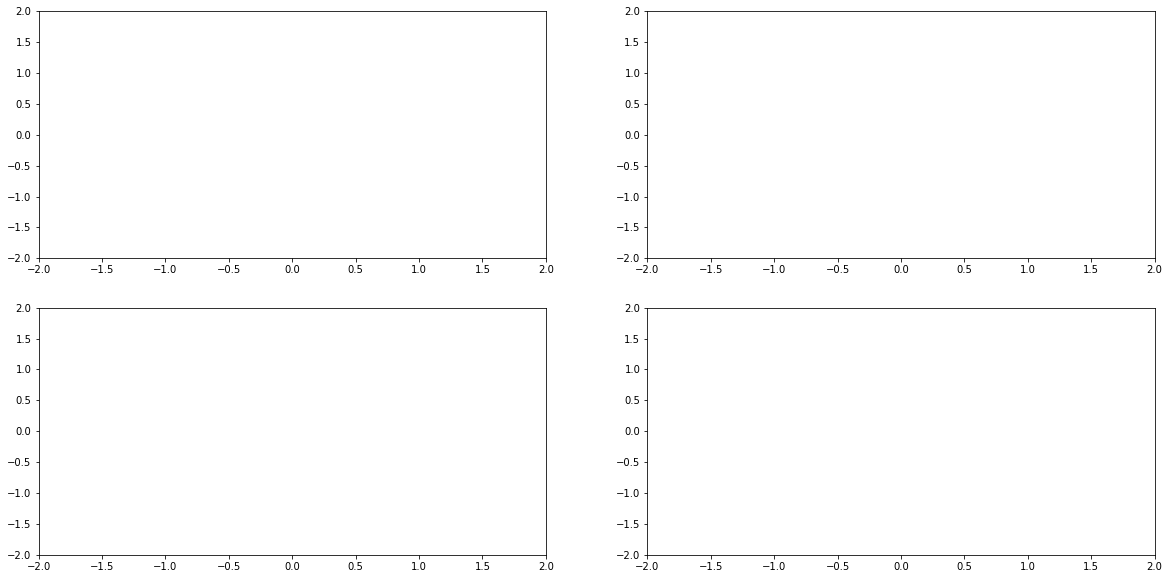

In [12]:
frames = 80 #test
#frames = 200 #visualize

#dpi = 200 #beautiful
dpi = 50 #fast

anim = visualizer.animate_organism(graph, network, food=30, frames=frames) 
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=dpi)

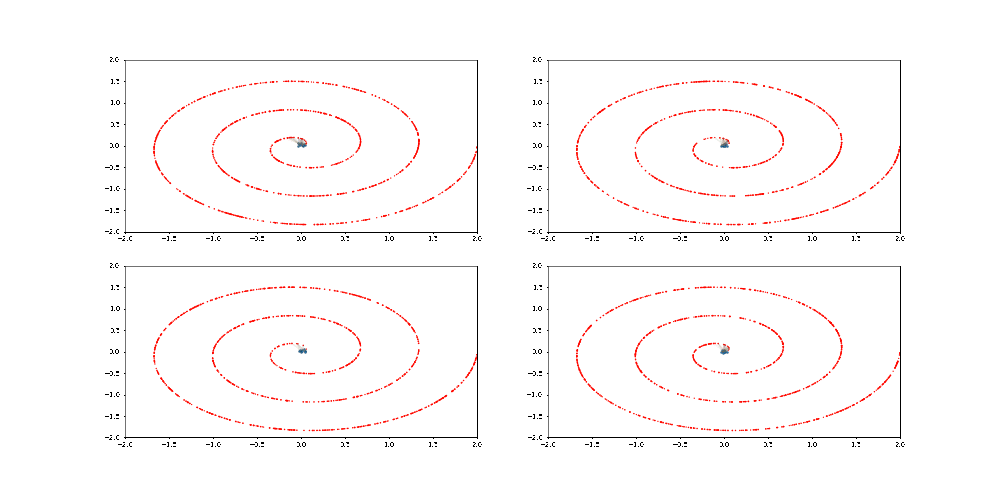

In [13]:
Image('../animation/' + name + '.gif')

In [14]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

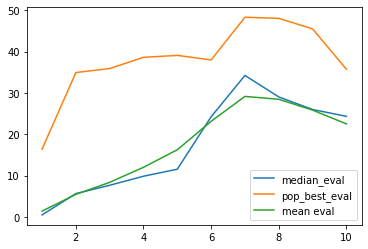

In [15]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

if settings.train_config.problem_searcher == ProblemSearcher.GeneticAlgorithm:
    plt.plot(losses.obj0_median_eval)
    plt.plot(losses.obj0_pop_best_eval)
    plt.plot(losses.obj0_mean_eval)
else:
    plt.plot(losses.median_eval)
    plt.plot(losses.pop_best_eval)
    plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()